# Rectified Flow
This jupyter notebook contains simple tutorial code for Rectified Flow proposed in '[Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/abs/2209.03003)'.

The problem here is to learn an ODE $\dot Z_t = v(Z_t, t) $ to transfer data from $\pi_0$ to $\pi_1$, where both $\pi_0$ and $\pi_1$ are unknown and empirically observed through a set of points.

The velocity field $v(z,t)$ in rectified flow can be fitted with either kernel method or deep neural networks. This tutorial illustrates the use of a neural network.

## Generating Distribution $\pi_0$ and $\pi_1$
We generate $\pi_0$ and $\pi_1$ as two Gaussian mixture models with different modes.

We sample 10000 data points from $\pi_0$ and $\pi_1$, respectively,
and store them in ```samples_0```, ```samples_1```.

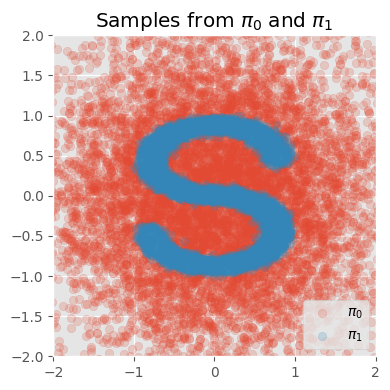

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily

D = 10.
M = D + 5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

# initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
# initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
# initial_model = MixtureSameFamily(initial_mix, initial_comp)
# samples_0 = initial_model.sample([10000])

# target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
# target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
# target_model = MixtureSameFamily(target_mix, target_comp)
# samples_1 = target_model.sample([10000])
# print('Shape of the samples:', samples_0.shape, samples_1.shape)

from sklearn.datasets import make_s_curve
from sklearn.preprocessing import MinMaxScaler
num_samples = int(1e4)
scaler = MinMaxScaler()

s_curve, _ = make_s_curve(num_samples, noise = 0.1, random_state = 42)
s_curve = s_curve[:, [0, 2]]
scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
s_curve = scaler.fit_transform(s_curve)
M = 2.0
samples_0 = torch.randn((num_samples, 2)).float()
samples_1 = torch.from_numpy(s_curve).float()
plt.figure(figsize=(4,4))
plt.xlim(-M, M)
plt.ylim(-M, M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].numpy(), samples_0[:, 1].numpy(), alpha=0.2, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].numpy(), samples_1[:, 1].numpy(), alpha=0.2, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

## Define the Flow Model
Given empirical observations of $X_0\sim \pi_0$ and $X_1\sim \pi_1$,
the rectified flow induced from $(X_0,X_1)$
is an ordinary differentiable model (ODE)
on time $t\in[0,1]$,
$$
\mathrm{d} Z_t = v^X(Z_t, t)  \mathrm{d} t
$$
which $v$ is set in a way that ensures that $Z_1$ follows $\pi_1$ when $Z_0 \sim \pi_0$. Let $X_t = t X_1 + (1-t)X_0$ be the linear interpolation of $X_0$ and $X_1$. Then $v$ is given by
$$
v^X(z,t) = \mathbb{E}[X_1 - X_0 ~|~ X_t = z  ] =  \arg\min_{v} \int_0^1 \mathbb{E}[|| X_1-X_0 - v(X_t,t) ||^2] \mathrm{d} t,
$$
where the (conditional) expectation is w.r.t. the joint distribution of $(X_0,X_1)$.

We parameterize $v^X(z,t)$ with a 3-layer neural network.

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

Then we define the rectfied flow class.

In [3]:
class RectifiedFlow():
    def __init__(self, model: nn.Module, num_steps: int = 1000):
        self.model = model
        self.N = num_steps

    def get_train_tuple(self, z0: torch.Tensor, z1: torch.Tensor):
        t = torch.rand((z1.size(0), 1))
        z_t =  t * z1 + (1.0 - t) * z0
        target = z1 - z0

        return z_t, t, target

    @torch.no_grad()
    def sample_ode(self, z0: torch.Tensor, N: int = None):
        ### NOTE: Use Euler method to sample from the learned flow
        N = N or self.N
        dt = 1./N
        traj = [] # to store the trajectory
        z = z0.detach().clone()
        batchsize = z.shape[0]

        traj.append(z.detach().clone())
        for i in range(N):
            t = torch.ones((batchsize, 1)) * i / N
            pred = self.model(z, t)
            z = z.clone() + pred * dt

            traj.append(z.clone())

        return traj

## Define the training method and other misc. code
We define the training method here. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{X_0 \sim \pi_0, X_1 \sim \pi_1} \left [ {||( X_1 - X_0) - v_\theta\big (X_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
X_t = t X_1 + (1-t) X_0.
$$

In [4]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters+1):
        indices = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indices]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

        pred = rectified_flow.model(z_t, t)
        # loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        # loss = loss.mean()
        loss = F.mse_loss(target, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_curve.append(np.log(loss.item())) ## to store the loss curve

    return rectified_flow, loss_curve


Misc. code for plotting figures.

In [9]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
    traj = rectified_flow.sample_ode(z0=z0, N=N)

    plt.figure(figsize=(4,4))
    plt.xlim(-M, M)
    plt.ylim(-M, M)

    plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
    plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
    plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
    plt.legend()
    plt.title('Distribution')
    plt.tight_layout()

    traj_particles = torch.stack(traj)
    plt.figure(figsize=(4,4))
    plt.xlim(-M,M)
    plt.ylim(-M,M)
    plt.axis('equal')
    for i in range(30):
        plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
    plt.title('Transport Trajectory')
    plt.tight_layout()

## 1-Rectified Flow
We start by generating the pairs $(X_0, X_1)$ by pooling randomly sampled points from ```sample_0``` and ```sample_1```. So $(X_0,X_1)$ forms an independent coupling of $\pi_0$ and $\pi_1$.


In [6]:
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)

torch.Size([10000, 2, 2])


We create ```rectified_flow_1``` and its corresponding ```optimizer``` and traing 1-Rectified Flow with ```train_rectified_flow``` using $(X_0, X_1)$ above.

Text(0.5, 1.0, 'Training Loss Curve')

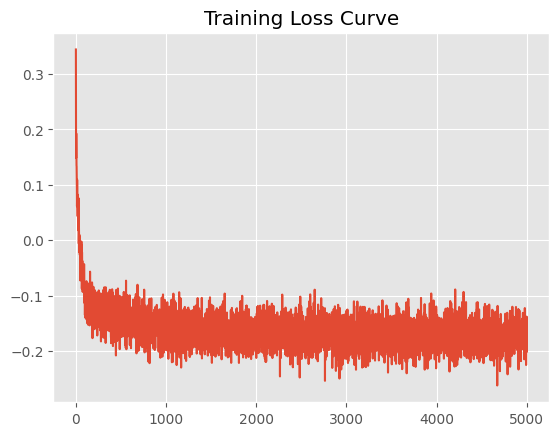

In [7]:
iterations = 5000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

We run the Euler method to solve the ODE with $N=1000$ steps to generate samples from 1-Rectified Flow.

Orange dots = samples from $\pi_0$

Blue dots   = samples from $\pi_1$

Green dots  = samples from 1-Rectified Flow

1-Rectified Flow successfully learned a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

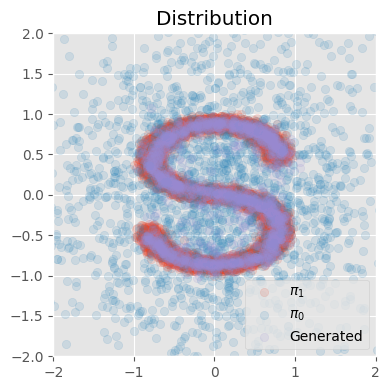

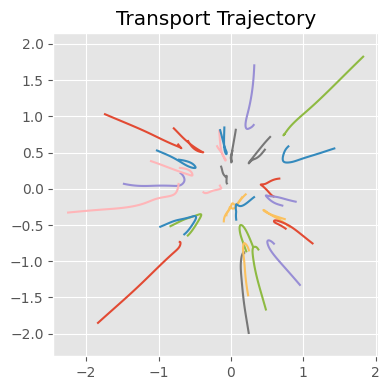

In [10]:
# draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)
draw_plot(rectified_flow_1, z0=torch.randn((2000, 2)), z1=samples_1.detach().clone(), N=100)

We can see that the trajectories above fit well on the trajectories of linear intepolation of data, but are "rewired" in the center when the trajectories are intersect. Hence, the resulting trajectories are either (almost)straight, or has a ">" shape.

Due to the non-straight ">"-shape paths, if we simulate the ODE with a small step $N$, we would obtain poor performance, as shown below ($N=1$).

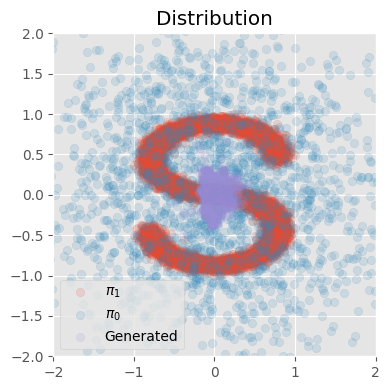

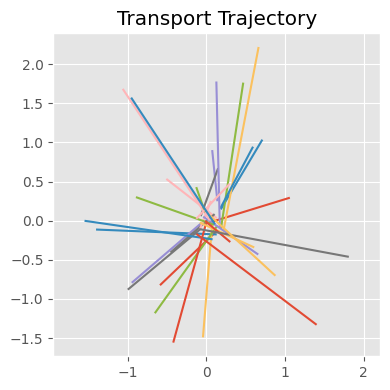

In [11]:
draw_plot(rectified_flow_1, z0=torch.randn((2000, 2)), z1=samples_1.detach().clone(), N=1)

## Reflow for 2-Rectified Flow
Now let's use the **reflow** procedure to get a straightened rectified flow, denoted as 2-Rectified Flow, by repeating the same procedure on with $(X_0, X_1)$ replaced by  $(Z_0^1, Z_1^1)$, where $(Z_0^1, Z_1^1)$ is the coupling simulated from 1-Rectified Flow. 
Specifically, we randomly sample 10000 $Z_0^1$  and generate their corresponding  $Z_1^1$ by simulating 1-Rectified Flow.

In [12]:
z10 = samples_0.detach().clone()
traj = rectified_flow_1.sample_ode(z0=z10.detach().clone(), N=100)
z11 = traj[-1].detach().clone()
z_pairs = torch.stack([z10, z11], dim=1)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


The coupling $(Z_0^1, Z_1^1)$ is now deterministic. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{(Z_0, Z_1) \sim (Z_0^1, Z_1^1)} \left [ {||( Z_1 - Z_0) - v_\theta\big (Z_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
Z_t = t Z_1 + (1-t) Z_0.
$$

We create ```rectified_flow_2``` and its corresponding ```optimizer``` and traing 2-Rectified Flow with ```train_rectified_flow```.

We use the model pretrained in 1-Rectified Flow to accelerate training.

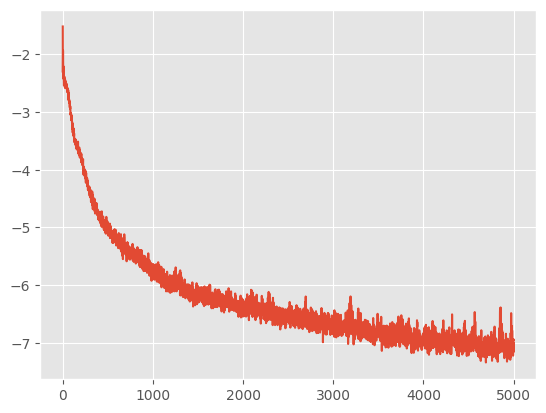

In [13]:
reflow_iterations = 5000

rectified_flow_2 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
import copy
rectified_flow_2.net = copy.deepcopy(rectified_flow_1) # we fine-tune the model from 1-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow_2.model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve = train_rectified_flow(rectified_flow_2, optimizer, z_pairs, batchsize, reflow_iterations)
plt.plot(np.linspace(0, reflow_iterations, reflow_iterations+1), loss_curve[:(reflow_iterations+1)])

We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 2-Rectified Flow.

2-Rectified Flow can also successfully learn a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

The key point, however, is that the transport trajectory is now **straightened** and hence we would not lose much accuracy even if we solve the ODE with one Euler step ($N=1$).

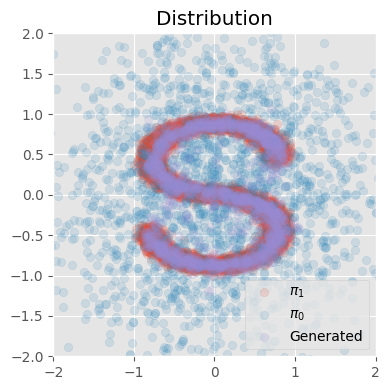

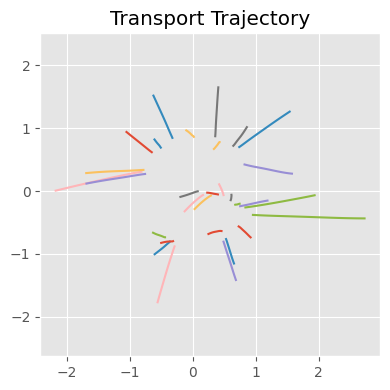

In [14]:
draw_plot(rectified_flow_2, z0=torch.randn((2000, 2)), z1=samples_1.detach().clone())

So below is the result when we solve the ODE with $N=1$ Euler step to generate samples from 2-Rectified Flow.

With the **straightened** trajectory, we get almost perfect results with only  one-step generation! Thanks to the power of **Reflow** !

More croncretely, the output of the model is now $Z_1 = Z_0 + v(Z_0, 0)$.

Effectively, we have trained a one-step model, by using ODE as an intermediate step.

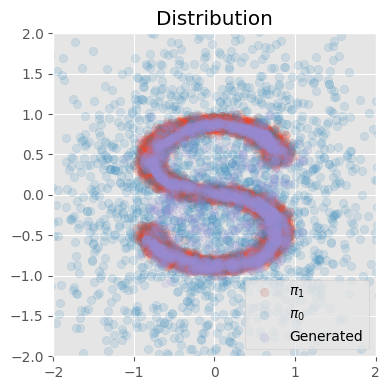

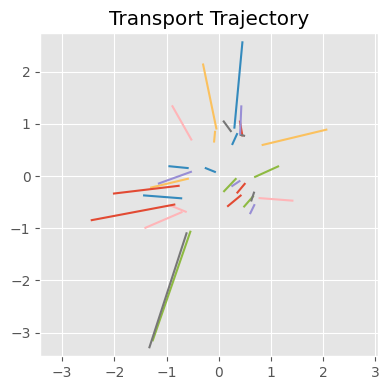

In [15]:
draw_plot(rectified_flow_2, z0=torch.randn((2000, 2)), z1=samples_1.detach().clone(), N=1)